# 1, Data preprocessing

In [25]:
# https://stackoverflow.com/questions/54473254/cudnnlstm-unknownerror-fail-to-find-the-dnn-implementation

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [26]:
### set the random seed 

tf.random.set_seed(9)

import random 
random.seed(9)

### 1, Load and extract the data

In [27]:
### extracting the entities and tags

import os 
from tensorflow.keras.preprocessing.sequence import pad_sequences


def split_text_label(filename):
    '''
    Reads a file named filename, extracts the text and the labels and stores
    them in an array.
     
    returns [ ['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O'] ] 
    '''
    
    # open file
    f = open(filename)
    
    # initializing
    split_labeled_text = []
    sentence = []
    
    # processing line by line 
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\t":
            if len(sentence) > 0:
                split_labeled_text.append(sentence)
                sentence = []
            continue
        
        # split by tab
        splits = line.split('	')
        # rstrip: strip from the right 
        sentence.append([splits[0],splits[-1].rstrip("\n")])
        
        
    if len(sentence) > 0:
        split_labeled_text.append(sentence)
        sentence = []
    return split_labeled_text



### Loading in the Raw_Corpus and split into train, valid, test

In [28]:

# load in data
all_data = split_text_label(os.path.join("Tagged_corpus_2021_12_07_1.txt"))
print("Length of all data: ", len(all_data))
print()


shuffle_data = random.shuffle(all_data)

# split into train, valid, test by precentage
train_num = round(len(all_data) * 0.8)
valid_num = round(len(all_data) * 0.2)
# test_num = round(len(all_data) * 0.2)

# here we do not use cross validation, just use train and valid with 4:1
split_train = all_data[:train_num]
split_valid = all_data[train_num:]
split_test = all_data[train_num:]

print("Length of training data: ", len(split_train))
print("Length of validing data: ", len(split_valid))
print("Length of testing data: ", len(split_test))

Length of all data:  1152

Length of training data:  922
Length of validing data:  230
Length of testing data:  230


In [29]:
# print some list to see 

print("training data: ", split_train[0:1])
print()

print("validing data: ", split_valid[0:1])
print()

print("testing data: ", split_test[0:1])
print()

training data:  [[['the', 'O'], ['odds', 'O'], ['of', 'O'], ['clinical', 'O'], ['ketosis', 'B-DIS'], ['were', 'O'], ['63', 'O'], ['times', 'O'], ['greater', 'O'], ['in', 'O'], ['cows', 'O'], ['with', 'O'], ['serum', 'O'], ['nefa', 'B-NUT'], ['?', 'O'], ['10', 'O'], ['mmol/l', 'O'], ['in', 'O'], ['the', 'O'], ['first', 'O'], ['week', 'O'], ['after', 'O'], ['calving', 'O']]]

validing data:  [[['one', 'O'], ['of', 'O'], ['the', 'O'], ['possible', 'O'], ['hepatic', 'O'], ['pathways', 'O'], ['of', 'O'], ['these', 'O'], ['metabolites', 'O'], ['and', 'O'], ['the', 'O'], ['one', 'O'], ['that', 'O'], ['is', 'O'], ['favoured', 'O'], ['in', 'O'], ['times', 'O'], ['of', 'O'], ['intense', 'O'], ['lipolysis', 'B-DIS'], ['and', 'O'], ['muscle', 'B-DIS'], ['breakdown', 'I-DIS'], ['leads', 'O'], ['to', 'O'], ['a', 'O'], ['production', 'B-DIS'], ['of', 'O'], ['ketone', 'B-NUT'], ['bodies', 'O'], ['(acetone', 'O'], ['acetoacetate', 'O'], ['ß-hydroxybutyrate', 'O'], ['[bhb])', 'O'], ['and', 'O'], ['their

### 2, Buidling Vocabulary

### build a vocabulary for the text, so we can assign a unique index for each word

In [30]:
### use labelSet() as label dictionary 
### use wordSet() as word dictionary 

labelSet = set()
wordSet = set()
# words and labels
for data in [split_train, split_valid, split_test]:
    for labeled_text in data:
        for word, label in labeled_text:
            
            # modifying unwanted mistag
            if label == 'i-NUT':
                label = 'I-NUT'
            if label == '':
                label = 'O'
            
            
            labelSet.add(label)
            wordSet.add(word.lower())
            


# modifying the label set 
print()
#empty = labelSet.pop()
labelSet.remove('"performance')
labelSet.remove('"results')
labelSet.remove('"cow')
labelSet.remove('"cows')
labelSet.remove('"ration')
labelSet.remove('"cattle')
labelSet.remove('"2000)')
labelSet.remove('"in')
labelSet.remove('"')
labelSet.remove('"e')
labelSet.remove('"disorders')
labelSet.remove('"staggers')

# check for the len 
print("labelSet: ", len(labelSet))
print("labelSet: ", labelSet)
print()
print("wordSet: ", len(wordSet))



labelSet:  5
labelSet:  {'B-NUT', 'B-DIS', 'O', 'I-DIS', 'I-NUT'}

wordSet:  4067


### 3, Assiging index 

In [31]:
### label2Idx  word2Idx


# sort the set to ensure '0' is assigned to 0
sorted_labels = sorted(list(labelSet), key=len)


# create mapping for labels
label2Idx = {}
for label in sorted_labels:
    label2Idx[label] = len(label2Idx)
idx2Label = {v: k for k, v in label2Idx.items()}


# create mapping for words
word2Idx = {}
if len(word2Idx) == 0:
    word2Idx["PADDING_TOKEN"] = len(word2Idx) # as 0
    word2Idx["UNKNOWN_TOKEN"] = len(word2Idx) # as 1
for word in wordSet:
    word2Idx[word] = len(word2Idx)
    
# print some mapping 

print("idx2Label: ", len(idx2Label))
print("idx2Label: ", idx2Label)
print()
print("word2Idx: ", len(word2Idx))
print("word2Idx: ", word2Idx)

idx2Label:  5
idx2Label:  {0: 'O', 1: 'B-NUT', 2: 'B-DIS', 3: 'I-DIS', 4: 'I-NUT'}

word2Idx:  4069
word2Idx:  {'PADDING_TOKEN': 0, 'UNKNOWN_TOKEN': 1, 'abnormal': 2, '1980;': 3, 'ideally': 4, 'defable': 5, '15%': 6, 'subclinically': 7, 'bi-directional': 8, '(mcart': 9, 'costs;': 10, 'fever]': 11, 'involving': 12, 'increases': 13, 'injecting': 14, 'guess': 15, '275': 16, '(1998b)': 17, 'cutoff': 18, 'problem': 19, 'neb-related': 20, 'speculated': 21, 'characterized': 22, 'markers': 23, 'drug': 24, '1979;': 25, 'curves': 26, 'encompassing': 27, '(christenson': 28, 'daily': 29, '400kg': 30, '2020)': 31, 'involution': 32, 'high-starch': 33, '(sanchez': 34, 'phenomena': 35, 'monensin': 36, 'farms': 37, '(dmi)': 38, 'furthermore': 39, 'adipose': 40, 'conclusions': 41, 'data': 42, 'sealant': 43, 'conventional': 44, 'alternatively': 45, 'mammary': 46, 'developments': 47, 'describe': 48, 'depressed;': 49, 'trivial': 50, 'pushing': 51, '?hydroxybutyrate': 52, 'evaluated': 53, 'programmed': 54, 

### 4, Change words into representive index

In [32]:
def createMatrices(data, word2Idx, label2Idx):
    sentences = []
    labels = []
    
    # get data 
    for split_labeled_text in data:
        wordIndices = []
        labelIndices = []
        
        # get word and data
        for word, label in split_labeled_text:
            
            try:
                # if is in the vocabulary
                if word in word2Idx:
                    wordIdx = word2Idx[word]

                # if the lower case version is in the vocabulary
                elif word.lower() in word2Idx:
                    wordIdx = word2Idx[word.lower()] 

                # if not, assign to the unknown token 
                else:                
                    wordIdx = word2Idx['UNKNOWN_TOKEN']

                # assign to the corrsponding index
                wordIndices.append(wordIdx)

                # fixing a bug of '' 
                if label != '':
                    labelIndices.append(label2Idx[label])
                    
            except KeyError:
                pass
    
        # append the index to sentences
        sentences.append(wordIndices)
        labels.append(labelIndices)
    return sentences, labels

train_sentences, train_labels = createMatrices(split_train, word2Idx, label2Idx)
valid_sentences, valid_labels = createMatrices(split_valid, word2Idx, label2Idx)
test_sentences, test_labels = createMatrices(split_test, word2Idx, label2Idx)

# print to check 

print("train_sentences, train_labels: ", train_sentences[0:5],'\n', train_labels[0:5])
print()
print("valid_sentences, valid_labels: ", valid_sentences[0:5], valid_labels[0:5])
print()
print("test_sentences, test_labels: ", test_sentences[0:5], test_labels[0:5])

train_sentences, train_labels:  [[2111, 109, 1580, 2828, 2121, 1505, 3073, 2893, 1003, 2894, 2668, 309, 2975, 409, 3674, 1827, 3403, 2894, 2111, 3509, 2289, 1102, 1415], [2111, 1751, 1803, 2111, 3237, 2943, 1580, 3062, 3240, 2781, 2558, 3884, 2673, 3612, 2558, 760, 3244, 2111, 3275, 2438, 2558, 760, 625, 1803, 2111, 3360, 3760, 2894, 2057, 978, 166, 2058, 3760, 2111, 826, 1803, 3203, 1868, 3818], [2111, 3380, 1744, 1505, 2656, 3976, 2458, 2287, 3982, 3803, 166, 409, 3954, 2513, 2334, 3760, 2111, 826, 1580, 1865, 3954, 2045, 2004, 3954, 657, 3816, 1429, 2111, 1809, 835, 544, 1216, 3589, 2111, 2634, 1580, 2905, 3557, 2894, 3497, 174, 244, 3736, 1168, 227, 1989, 1170, 309, 2111, 1451, 1580, 3535, 1489, 166, 1505, 3803, 409, 3954, 2513, 2287, 2166, 3720, 1168, 2065, 554, 3498, 3821, 2810, 1457, 1145, 271, 739, 1512, 2111, 1387, 1580, 2860, 2505, 2167, 2121, 2894, 533, 881, 244, 3881, 2458, 2786, 3747, 826, 405, 1803, 2668, 3884, 2247, 3588, 3954, 2747, 1168, 2111, 1332, 2109, 1580, 3582, 1

### 5, Pad the sentence into the same length

### for fast computation

In [33]:
### padding with packages 'pad_sequences'

# ========== set the max length ========== 
max_seq_len = 128

def padding(sentences, labels, max_len, padding='post'):
    padded_sentences = pad_sequences(sentences, max_len,       
    padding='post')
    padded_labels = pad_sequences(labels, max_len, padding='post')
    return padded_sentences, padded_labels

train_features, train_labels = padding(train_sentences, train_labels, max_seq_len, padding='post' )
valid_features, valid_labels = padding(valid_sentences, valid_labels, max_seq_len, padding='post' )
test_features, test_labels = padding(test_sentences, test_labels, max_seq_len, padding='post' )

# check for the results 
print(len(train_features[1]) == len(train_features[2]))
print()
print("train_features, train_labels: ", train_features[0:1], train_labels[0:1])
print()
print("valid_features, valid_labels: ", valid_features[0:1], valid_labels[0:1])
print()
print("test_features, test_labels: ", test_features[0:1], test_labels[0:1])

True

train_features, train_labels:  [[2111  109 1580 2828 2121 1505 3073 2893 1003 2894 2668  309 2975  409
  3674 1827 3403 2894 2111 3509 2289 1102 1415    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] [[0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

valid_features, valid_labels:  [[ 

### =====

# 2, Using the Global Vector Word Embedding

### Glove is a vector for word embedding, the machine understand the words by the location of them in the vector space

In [34]:
import numpy as np

# set the dimension for each word 
EMBEDDING_DIM = 100

# loading glove embeddings
embeddings_index = {}
f = open('embeddings/glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.strip().split(' ')
    word = values[0] # the first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') #100d vectors  representing the word
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((len(word2Idx), EMBEDDING_DIM))

# word embeddings for the tokens
for word,i in word2Idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 3, Training with tensorflow

### 1, Batching and shuffling the dataset

In [35]:
### using tf.data.Dataset.from_tensor_slices 

# import tensorflow as tf
from tensorflow.keras import layers

train_batch_size = 64
valid_batch_size = 64
test_batch_size = 64


train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_features, valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

# shuffling the training dataset 
shuffled_train_dataset = train_dataset.shuffle(buffer_size=train_features.shape[0], reshuffle_each_iteration=True)

# batching the three datasets
batched_train_dataset = shuffled_train_dataset.batch(train_batch_size, drop_remainder=True) # drop_remiainder: ignore the last batch if nesscery
batched_valid_dataset = valid_dataset.batch(valid_batch_size, drop_remainder=True)
batched_test_dataset = test_dataset.batch(test_batch_size, drop_remainder=True)

# checking 
print("batched_train_dataset: ", batched_train_dataset)
print("batched_valid_dataset: ", batched_valid_dataset)
print("batched_test_dataset: ", batched_test_dataset)

batched_train_dataset:  <BatchDataset shapes: ((64, 128), (64, 128)), types: (tf.int32, tf.int32)>
batched_valid_dataset:  <BatchDataset shapes: ((64, 128), (64, 128)), types: (tf.int32, tf.int32)>
batched_test_dataset:  <BatchDataset shapes: ((64, 128), (64, 128)), types: (tf.int32, tf.int32)>


### 2, Bi-direction Long-Short-Term Memory Neural Network (Bi-LSTM)

In [36]:
### class TFNer

class TFNer(tf.keras.Model):
    
    def __init__(self, max_seq_len, embed_input_dim, embed_output_dim, num_labels, weights):
        super(TFNer, self).__init__()
        
        # Embedding layer
        self.embedding = layers.Embedding(input_dim=embed_input_dim, 
                                          output_dim=embed_output_dim, 
                                          weights=weights, 
                                          input_length=max_seq_len, 
                                          trainable=False, 
                                          mask_zero=True)
        
        # Bidrectional layer
        self.bilstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        
        # Dense layer
        self.dense = layers.Dense(num_labels)

    def call(self, inputs):
        x = self.embedding(inputs) # batchsize, max_seq_len, embedding_output_dim
        x = self.bilstm(x) # batchsize, max_seq_len, hidden_dim_bilstm
        logits = self.dense(x) # batchsize, max_seq_len, num_labels
        
        # return a logist score
        return logits

# 3, Training 

In [37]:
# os
import os

# math
import math

# pickle: serializes objects so they can be saved to a file, 
# and loaded in a program again later on
import pickle

# logging: use 'logger' to log messages 
# have 5 levels: DEBUG, INFO, WARNING, ERROR, CRITICAL
import logging

# to create the the command line interface
import argparse

# itertoole
import itertools

# numpy
import numpy as np

# tf
from tensorflow import keras

# from model import TFNer

# pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

# master_bar, progress_bar 
from fastprogress.fastprogress import master_bar, progress_bar

# from preprocess import split_text_label, padding, createMatrices

# seqeval: for sequence labeling 
from seqeval.metrics import classification_report

In [38]:
# variables for model
num_labels = len(label2Idx)
idx2Label = {v: k for k, v in label2Idx.items()}

# model
model = TFNer(max_seq_len=max_seq_len,embed_input_dim=len(word2Idx), embed_output_dim=EMBEDDING_DIM, weights=[embedding_matrix], num_labels=num_labels)


# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# losses: scce
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [39]:
# train_dataset

# valid_dataset

### 1, Set the logging and progress bar 

In [40]:
### fastprogress

# ========== num of epochs ==========
epochs = 10

# train_pd_max_len, valid_pb_max_len, test_pb_max_len
epoch_bar = master_bar(range(epochs))
train_pb_max_len = math.ceil(float(len(train_features))/float(train_batch_size))
valid_pb_max_len = math.ceil(float(len(valid_features))/float(valid_batch_size))
test_pb_max_len = math.ceil(float(len(test_features))/float(test_batch_size))

In [41]:
### tf.summary.create_file_writer: a trianing log 

train_log_dir = f"/logs"
valid_log_dir = f"/logs"
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
valid_summary_writer = tf.summary.create_file_writer(valid_log_dir)

### 2, Custom training loop 

In [42]:
# training loss
train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)

# validing loss
valid_loss_metric = tf.keras.metrics.Mean('valid_loss', dtype=tf.float32)

# customize training loop
def train_step_fn(sentences_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits = model(sentences_batch) # batchsize, max_seq_len, num_labels
        loss = scce(labels_batch, logits) # batchsize,max_seq_len
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
    return loss, logits

# customize validing loop 
def valid_step_fn(sentences_batch, labels_batch):
    logits = model(sentences_batch)
    loss = scce(labels_batch, logits)
    return loss, logits


for epoch in epoch_bar:
    
    # customize training epoch bar 
    with train_summary_writer.as_default():
        for sentences_batch, labels_batch in progress_bar(
            batched_train_dataset, 
            total=train_pb_max_len, 
            parent=epoch_bar):

            loss, logits = train_step_fn(sentences_batch, labels_batch)
            
            train_loss_metric(loss)
            
            epoch_bar.child.comment = f'training loss : {train_loss_metric.result()}'
        
        tf.summary.scalar('training loss', train_loss_metric.result(), step=epoch)
        train_loss_metric.reset_states()
    
    # customize validing epoch bar 
    with valid_summary_writer.as_default():
        for sentences_batch, labels_batch in progress_bar(
            batched_valid_dataset, 
            total=valid_pb_max_len, 
            parent=epoch_bar):
            
            loss, logits = valid_step_fn(sentences_batch, labels_batch)
            
            valid_loss_metric.update_state(loss)

            epoch_bar.child.comment = f'validation loss : {valid_loss_metric.result()}'

        # logging after each epoch !
        tf.summary.scalar('valid loss', valid_loss_metric.result(), step=epoch)
        valid_loss_metric.reset_states()

model.save_weights(f"./model_weights",save_format='tf')  
# logger.info(f"Model weights saved")

# 4, Evaluating model performance on the test dataset

### 1, two functions

In [43]:

### assgining the label to each word 

def idx_to_label(predictions, correct, idx2Label):
    """
    input: 
        predictions: predicitons of the model (idx)
        correct: targets from the text (idx)
    output: 
        label_correct: predicitons of the model (label)
        label_pred: targets from the text (label)
    """
    label_pred = []    
    for sentence in predictions:
        for i in sentence:
            label_pred.append([idx2Label[elem] for elem in i ]) 

    label_correct = []  
    if correct != None:
        for sentence in correct:
            for i in sentence:
                label_correct.append([idx2Label[elem] for elem in i ]) 
        
    return label_correct, label_pred

### predict each sentence: using pad_sequences

def predict_single_sentence(sentence, word2Idx, max_seq_len):
    """
    input: 
        sentence: string
        word2Idx: function
        max_seq_len: int
    output: 
        length: int
        masks: array of 1 and 0
        padded_inputs: array of padded index for the sentence 
    """
    sentence = list(sentence.split(" "))
    sentences = []
    wordIndices = []
    masks = []
    length = len(sentence)

    # assining index to the sentence
    for word in sentence:
        if word in word2Idx:
            wordIdx = word2Idx[word]
        elif word.lower() in word2Idx:
            wordIdx = word2Idx[word.lower()]                 
        else:                
            wordIdx = word2Idx['UNKNOWN_TOKEN']
        wordIndices.append(wordIdx)

    # len of mask = len of sentence 
    maskindices = [1]*len(wordIndices)

    # append
    sentences.append(wordIndices)
    masks.append(maskindices)

    padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        sentences, 
        maxlen=max_seq_len, 
        padding="post")

    masks = tf.keras.preprocessing.sequence.pad_sequences(
        masks, 
        maxlen=max_seq_len, 
        padding="post")

    return length, masks, padded_inputs

    

### 2, Loading the model 

In [44]:

test_batch_size = 64

# padding sentences and labels to max_length of 128
max_seq_len = 128
EMBEDDING_DIM = 100


# idx2Label = pickle.load(open(os.path.join("idx2Label.pkl"), 'rb'))
label2Idx = {v:k for k,v in idx2Label.items()}
num_labels = len(label2Idx)


# word2Idx = pickle.load(open(os.path.join("word2Idx.pkl"), 'rb'))
# Embedding_matrix = pickle.load(open(os.path.join("embedding.pkl"), 'rb'))
# logger.info("Loaded idx2Label, word2Idx and Embedding matrix pickle files")

# loading the model
testmodel =  TFNer(
    max_seq_len=max_seq_len, 
    embed_input_dim=len(word2Idx), 
    embed_output_dim=EMBEDDING_DIM, 
    weights=[embedding_matrix], 
    num_labels=num_labels)

# testmodel.load_weights(f"{args.model_dir}/model_weights")
testmodel.load_weights("./model_weights")
# logger.info("Model weights restored")


    



### 3, Evaluation on the test set 

In [45]:
### processing the test set 

# extract from the txt
# split_test = split_text_label("test.txt")

# indexing 
test_sentences, test_labels = createMatrices(split_test, word2Idx, label2Idx)

# padding
test_features, test_labels = padding(test_sentences, test_labels, max_seq_len, padding='post' )

# logger
# logger.info(f"Test features shape is {test_features.shape} and labels shape is{test_labels.shape}")

# input to tesorflow
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

# batching
batched_test_dataset = test_dataset.batch(test_batch_size, drop_remainder=True)

###  checking 

# print(test_features[0:5], test_labels[0:5])
print()
print(batched_test_dataset)

# print(test_sentences[0:5])


<BatchDataset shapes: ((64, 128), (64, 128)), types: (tf.int32, tf.int32)>


In [46]:
### output the test set evaluation results 


from seqeval.metrics import f1_score


### epoch_bar = master_bar(range(epochs))

test_pb_max_len = math.ceil(float(len(test_features))/float(test_batch_size))

true_labels = []
pred_labels = []

#for sentences_batch, labels_batch in progress_bar(batched_test_dataset, total=test_pb_max_len):

logits = testmodel(sentences_batch)
temp1 = tf.nn.softmax(logits)   
preds = tf.argmax(temp1, axis=2)
true_labels.append(np.asarray(labels_batch))
pred_labels.append(np.asarray(preds))

label_correct, label_pred = idx_to_label(pred_labels, true_labels, idx2Label)

#print(preds)
#print(pred_labels, true_labels)
#print(label_correct, label_pred)
# f1_score(pred_labels, true_labels)
print(classification_report(label_correct, label_pred))
#logger.info(f"\nResults for the test dataset") 
# logger.info(f"\n{report}")

print()
# print(label_pred[0:5])
print("The length of label_pred: ", len(label_pred))

              precision    recall  f1-score   support

         DIS       0.76      0.84      0.80        44
         NUT       0.82      0.79      0.80        47

   micro avg       0.79      0.81      0.80        91
   macro avg       0.79      0.81      0.80        91
weighted avg       0.79      0.81      0.80        91


The length of label_pred:  64


### ===== Plotting cm

In [47]:
# label_pred

concat_pred = []
for i in label_pred:
    concat_pred += i
    
concat_correct = []
for i in label_correct:
    concat_correct += i

In [48]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt  
import seaborn as sns

cm = confusion_matrix(concat_correct, concat_pred,  labels = ['O', 'B-DIS', 'I-DIS', 'B-NUT', 'I-NUT'])

[Text(0, 0.5, 'O'),
 Text(0, 1.5, 'B-DIS'),
 Text(0, 2.5, 'I-DIS'),
 Text(0, 3.5, 'B-NUT'),
 Text(0, 4.5, 'I-NUT')]

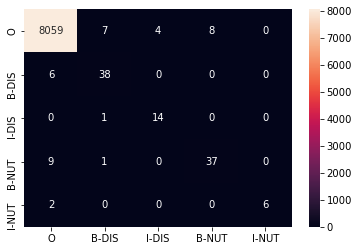

In [49]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.xaxis.set_ticklabels(['O', 'B-DIS', 'I-DIS', 'B-NUT', 'I-NUT'])
ax.yaxis.set_ticklabels(['O', 'B-DIS', 'I-DIS', 'B-NUT', 'I-NUT'])

### 4, Predictions

In [37]:
# import nltk
# ! pip install nltk 
# nltk.download()
# nltk.download('punkt')

### 5, Prediction for a single sentence

In [44]:
test_sentence = """Periparturient diseases such as milk fever, ketosis, and displaced abomasums can all be associated with poor transition"""

length, masks, padded_inputs = predict_single_sentence(test_sentence, word2Idx, max_seq_len)
padded_inputs = tf.expand_dims(padded_inputs, 0)

true_labels = None
pred_labels = []
pred_logits = []

for sentence in padded_inputs:
    logits = testmodel(sentence)
    temp1 = tf.nn.softmax(logits) 
    max_values = tf.reduce_max(temp1,axis=-1)

    masked_max_values = max_values * masks 
    preds = tf.argmax(temp1, axis=2)
    pred_labels.append(np.asarray(preds))
    pred_logits.extend(np.asarray(masked_max_values))
_,label_pred  = idx_to_label(pred_labels, true_labels, idx2Label)



label_pred = label_pred[0][:length] 
pred_logits = pred_logits[0][:length]



### the splited sentences: words 


import re
from nltk import word_tokenize 

# remove punct 
words = str(test_sentence)
words = re.sub(r"[^a-zA-Z0-9.?! ]+", "", words)
words = words.lower()

# tokenize
words = word_tokenize(words)

# check for length 
print(len(words) == len(label_pred))
print()
print(words)
print(label_pred)

True

['periparturient', 'diseases', 'such', 'as', 'milk', 'fever', 'ketosis', 'and', 'displaced', 'abomasums', 'can', 'all', 'be', 'associated', 'with', 'poor', 'transition']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DIS', 'I-DIS', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [43]:
### a pretter output 

ner_word = []
ner_label = []
for i, j in zip(words, label_pred): 
    if j != 'O':
        ner_word.append(i)
        ner_label.append(j)
        
# check and see 
print("ner_word: ", ner_word) 
print()
print("ner_label: ", ner_label) 

ner_word:  ['displaced', 'abomasums']

ner_label:  ['B-DIS', 'I-DIS']
